<a href="https://colab.research.google.com/github/qu1r0ra/philippine-language-clustering/blob/main/philippine_language_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Repository Setup

First, let us clone the GitHub repository containing code which our notebook relies on.

The primary reason as to why the authors decided to externalize most code via a repository is to integrate software engineering principles and practices into the project, thereby improving its cleanliness and quality.

Maintaining a GitHub repository alongside a Jupyter notebook (as opposed to relying solely on the notebook) allows for better code organization and version control. Code snippets for high-level tasks (e.g., preprocessing data, language modelling) can be refactored to scripts, making it easier to debug and modify code. Version control for these scripts is a given as we are utilizing Git.

In a sense, this notebook serves as a presentation layer which simply utilizes functions and classes abstracted by various Python scripts in the said GitHub repository.

In [1]:
import os

repo_url = "https://github.com/qu1r0ra/philippine-language-clustering.git"
repo_dir = "philippine-language-clustering"
branch = "main"

# Change to the working directory in Google Colab: /content
%cd /content

# Remove previous clone
if os.path.exists(repo_dir):
  print(f"\nRemoving old repo folder '{repo_dir}' to ensure a clean clone...")
  !rm -rf {repo_dir}
else:
  print(f"\nNo repo folder '{repo_dir}' found.")

# Clone the specified branch
print(f"\nCloning branch {branch} from repository...")
!git clone --branch {branch} --single-branch {repo_url} {repo_dir}

# Move into the cloned directory
%cd {repo_dir}

# Install or upgrade uv
print("\nInstalling/Upgrading uv...")
!pip install --upgrade uv --quiet

# Install dependencies using uv
if os.path.exists("pyproject.toml"):
  print("\nInstalling dependencies with uv...")
  !uv sync --quiet
else:
  print("\nNo pyproject.toml found — skipping uv install.")

print("\nSetup complete!")

/content

Removing old repo folder 'philippine-language-clustering' to ensure a clean clone...

Cloning branch main from repository...
Cloning into 'philippine-language-clustering'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 126 (delta 38), reused 36 (delta 15), pack-reused 50 (from 1)
Receiving objects: 100% (126/126), 580.04 KiB | 6.82 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/content/philippine-language-clustering

Installing/Upgrading uv...

Installing dependencies with uv...

Setup complete!


As Google Colab does not persist files uploaded into it, we need to clone the repository and upload the necessary files every time we work on the project. We may also need to save intermediary results.

## Data Setup

1. Create a `data` folder and a `zipped` folder inside `data`.
2. Download `segmented.zip` from [this GDrive link](https://drive.google.com/drive/folders/1hKNLOayge7rvjx5LNMzHrMoGJY7gTeAT?usp=sharing) and upload it to `data/zipped`.
3. Run the script below to unzip the segmented data.

In [2]:
import zipfile

data_root = "/content/data"
zip_dir = os.path.join(data_root, "zipped")
unzipped_dir = os.path.join(data_root, "unzipped")

os.makedirs(zip_dir, exist_ok=True)
os.makedirs(unzipped_dir, exist_ok=True)

# Loop through all zip files and extract them to the unzipped folder
for zip_file in os.listdir(zip_dir):
    zip_path = os.path.join(zip_dir, zip_file)
    if not zipfile.is_zipfile(zip_path):
          print(f"Skipping {zip_file} — not a valid ZIP file.")
          continue

    extract_folder_name = os.path.splitext(zip_file)[0]
    extract_path = os.path.join(unzipped_dir, extract_folder_name)
    os.makedirs(extract_path, exist_ok=True)

    print(f"\nExtracting {zip_file} → {extract_folder_name}/ ...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_path)
    print("\nDone!")

print("\nAll archives extracted.")
# !ls -R {unzipped_dir}



Extracting segmented.zip → segmented/ ...

Done!

All archives extracted.


## Cleaning and Preprocessing

In this section, we prepare our textual data for analysis by performing data cleaning and preprocessing. Each language corpus is loaded and standardized through the `LanguageData` class, which handles tasks such as removing unnecessary symbols (i.e., non-Unicode characters and extra spaces), tokenizing, and computing for average word length and sentence lengths.

The purpose of this step is to ensure consistency and comparability across all language corpora. Since our dataset consists of multiple Philippine languages with varying orthographic conventions, preprocessing guarantees that the text follows a uniform structure.

After loading and cleaning, a short summary is shown for each language to show the respective statistics stated above.

In [3]:
from src.cleaning_preprocessing import LanguageData

data_dir = os.path.join(unzipped_dir, "segmented/by_sentence")
languages = list(os.listdir(data_dir))

corpora = {}

for lang in languages:
  lang_path = os.path.join(data_dir, lang)
  lang_obj = LanguageData(lang, lang_path).load()
  corpora[lang] = lang_obj

  lang_obj.summary()
  print("-" * 40)


Language: Sambal
No. of sentences: 12291
Avg. word length: 4.82
Avg. sentence length: 18.05
----------------------------------------
Language: Ilokano
No. of sentences: 49843
Avg. word length: 5.21
Avg. sentence length: 12.92
----------------------------------------
Language: Ivatan
No. of sentences: 11183
Avg. word length: 4.10
Avg. sentence length: 22.98
----------------------------------------
Language: Tausug
No. of sentences: 16055
Avg. word length: 4.79
Avg. sentence length: 16.80
----------------------------------------
Language: Yami
No. of sentences: 16269
Avg. word length: 3.92
Avg. sentence length: 15.18
----------------------------------------
Language: Bikolano
No. of sentences: 48739
Avg. word length: 4.88
Avg. sentence length: 17.28
----------------------------------------
Language: Isnag
No. of sentences: 19884
Avg. word length: 4.29
Avg. sentence length: 15.74
----------------------------------------
Language: Yakan
No. of sentences: 16488
Avg. word length: 5.32
Avg. s

We can already see that some language corpora have more sentences than others (e.g., Kapampangan, Tagalog, Pangasinense) primarily due to them having more translated Bible books. This can already be an indicator of how these languages are high-resourced.

## Feature Engineering

Once the language data is cleaned, we proceed to feature engineering, where the textual information is transformed to numerical representations. Specifically, we extract character n-grams and word n-grams, which captures distinct language patterns at two levels of granularity.

* **Character n-grams** - A trigram was chosen (n=3) to capture subword patterns such as morphemes, syllabic patterns, or character substrings (e.g., "ang", "nga", "ng_")

* **Word n-grams** - A unigram was chosen to capture lexical-level differences by representing individual words from sentences


These features allow us to compare languages based on how often certain sequences of characters or words occur. Using the `FeatureSpaceBuilder` class, these per-language vectors are merged into a unified vocabulary, resulting to a table-like space that summarizes the linguistic profile of each language both per character and per word.

We chose to analyze them separately instead of combining them into one feature space.

In [4]:
from src.feature_engineering import LanguageFeatureExtractor

CHAR_NGRAM_N = 3 # @param {"type":"slider","min":1,"max":10,"step":1}
WORD_NGRAM_N = 1 # @param {"type":"slider","min":1,"max":5,"step":1}

feature_extractors = {}

for lang, lang_data in corpora.items():
  feat_extractor = LanguageFeatureExtractor(lang_data)
  feat_extractor.char_ngram(n=CHAR_NGRAM_N)
  feat_extractor.word_ngram(n=WORD_NGRAM_N)
  feature_extractors[lang] = feat_extractor

  feat_extractor.summary()
  print("-" * 40)


Language: Sambal
Avg. word length: 4.82
Avg. sentence length: 18.05

Top 20 character n-grams:
an : 29701
ay : 20425
 na: 17211
in : 16056
 a : 12937
 ko: 12908
 ka: 12869
 ta: 12732
 ma: 12452
 ha: 11599
on : 11290
ang: 9861
n a: 9581
ha : 9336
 ya: 9124
nan: 8429
na : 8301
 pa: 8213
 hi: 8075
a k: 7914

Top 20 word n-grams:
a: 12939
ha: 9326
na: 5569
ay: 4748
yay: 4650
nin: 4622
ta: 3825
nan: 3783
tan: 3634
dios: 3134
kay: 2231
ni: 2203
main: 2160
ko: 2126
la: 2008
jesus: 1975
hilay: 1858
kot: 1851
moyo: 1807
hi: 1770
----------------------------------------
Language: Ilokano
Avg. word length: 5.21
Avg. sentence length: 12.92

Top 20 character n-grams:
ti : 121426
iti: 64699
 ti: 57771
 a : 53489
 it: 36153
 da: 34872
agi: 34348
 ka: 33918
dag: 32682
git: 31363
 ke: 31316
nga: 28738
a a: 28669
 ma: 27840
an : 27730
i a: 26903
 na: 25168
ang: 24343
ada: 24321
en : 23221

Top 20 word n-grams:
ti: 56432
a: 53495
iti: 36503
dagiti: 19650
nga: 19349
ni: 17727
ken: 14316
ket: 12753
kadagit

We can see how different languages have different top-20 *character trigrams* and *word unigrams*.

Now that we have extracted n-grams from each language, we can proceed with building the *feature space* with class `FeatureSpaceBuilder`. It simply takes in language features (e.g., character trigrams, word unigrams) from each language and builds a standardized set of features consisting of unique ngrams across all languages. In other words, it is simply the union of all n-grams across all languages.

This feature space will then be used to create a vector representation for each language. Each dimension of the representation corresponds to a unique n-gram and the corresponding value will be the frequency of the said n-gram in the language, normalized to decimal. Hence, the number of dimensions of the representation will be equal to the number of unique n-grams found across all languages and the sum of all component values will equal to 1.

In [5]:
from src.feature_engineering import FeatureSpaceBuilder

# Initialize the global feature space
fs_builder = FeatureSpaceBuilder(feature_extractors)
fs_builder.build_feature_space()

# Retrieve feature matrices for inspection
char_matrix = fs_builder.as_matrix(kind="char")
word_matrix = fs_builder.as_matrix(kind="word")

Built global vocabularies: 12828 char n-grams, 221266 word n-grams.
Constructed normalized vectors for 16 languages.


In [6]:
char_matrix.head()

,a,a_,aa,ab,ac,ad,ae,af,ag,ah,...,ꞌīd,ꞌīg,ꞌīm,ꞌīn,ꞌīp,ꞌūa,ꞌūg,ꞌūh,ꞌūk,ꞌūs
Bikolano,0.000000e+00,0.000000e+00,0.000128,0.000205,0.000009,0.000042,2.037705e-07,0.000002,0.000219,0.000078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cebuano,2.186926e-07,0.000000e+00,0.000078,0.000265,0.000009,0.000879,2.186926e-07,0.000002,0.000185,0.000092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chavacano,5.009651e-06,0.000000e+00,0.000000,0.000381,0.000955,0.000253,7.156644e-07,0.000122,0.000221,0.000261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ilokano,1.354039e-02,2.531435e-07,0.000086,0.000313,0.000011,0.001273,0.000000e+00,0.000003,0.003621,0.000095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Isnag,4.308912e-04,7.945511e-06,0.000078,0.000389,0.000009,0.000491,0.000000e+00,0.000000,0.001166,0.000002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
word_matrix.head()

,a,aabaen,aabageyen,aabalaen,aabalaey,aabalahin,aabeng,aabenga,aaboluyan,aabot,...,ūsꞌūs,ūt,ūtanbi,ūtande,ūtanku,ūtanne,ūtante,ūtanun,ūūhun,ḻamḻamang
Bikolano,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cebuano,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chavacano,0.000025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ilokano,0.083054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Isnag,0.002295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We were able to construct a feature space with $12,828$ dimensions for character trigrams and $221,266$ dimensions for word unigrams.

## Clustering

With our numerical feature representations ready, we apply clustering techniques to group languages based on similarity. This process involves two major steps:

1. **Dimensionality Reduction**: Singular Value Decomposition (SVD) was chosen to compress the high-dimensional n-gram vectors into lower dimensions. SVD was chosen over Principal Component Analysis (PCA) as the former is more efficient and is said to work better for very high-dimensional data, such as that of our language representations.

2. **Clustering**: Agglomerative Clustering was chosen to identify language groupings without any prior labels. We technically could have chosen to go with K-means Clustering, but we honestly just wanted to try out agglomerative clustering.

To evaluate the quality of clusters, the *silhouette score* for a range of cluster numbers (k values) was computed. These scores measure how well languages fit within their assigned groups comparead to others.

The results are summarized and visualized in a line plot, allowing us to determine the optimal number of clusters for each n-gram representation.

In [8]:
from src.modeling import model_pipeline
import pandas as pd
import matplotlib.pyplot as plt

REDUCER_METHOD = "svd"  # @param ["svd","pca"]
CLUSTERER_METHOD = "agglomerative"  # @param ["agglomerative","kmeans"]
K_RANGE_START = 3  # @param {"type":"slider","min":2,"max":10,"step":1}
K_RANGE_STOP = 10  # @param {"type":"slider","min":2,"max":10,"step":1}
N_COMPONENTS = 50

k_range = range(K_RANGE_START, K_RANGE_STOP + 1)
results = []

for k in k_range:
    print(f"k = {k}")
    print("\n=== CHAR NGRAMS ===")
    _, _, _, _, char_score = model_pipeline(
        char_matrix,
        reducer_method=REDUCER_METHOD,
        n_components=N_COMPONENTS,
        clusterer_method=CLUSTERER_METHOD,
        n_clusters=k,
    )

    print("\n=== WORD NGRAMS ===")
    _, _, _, _, word_score = model_pipeline(
        word_matrix,
        reducer_method=REDUCER_METHOD,
        n_components=N_COMPONENTS,
        clusterer_method=CLUSTERER_METHOD,
        n_clusters=k,
    )

    print("-" * 40)

    results.append({
        "n_clusters": k,
        "char_score": char_score,
        "word_score": word_score
    })

# Create a summary DataFrame
results_df = pd.DataFrame(results)

# Display and visualize
display(results_df)

k = 3

=== CHAR NGRAMS ===
Reducing dimensionality using SVD (50 components)...
SVD retained variance: 98.40%
Clustering languages using AGGLOMERATIVE (3 clusters)...
Silhouette score: 0.1783

=== WORD NGRAMS ===
Reducing dimensionality using SVD (50 components)...
SVD retained variance: 98.58%
Clustering languages using AGGLOMERATIVE (3 clusters)...
Silhouette score: 0.1395
----------------------------------------
k = 4

=== CHAR NGRAMS ===
Reducing dimensionality using SVD (50 components)...
SVD retained variance: 98.40%
Clustering languages using AGGLOMERATIVE (4 clusters)...
Silhouette score: 0.1640

=== WORD NGRAMS ===
Reducing dimensionality using SVD (50 components)...
SVD retained variance: 98.58%
Clustering languages using AGGLOMERATIVE (4 clusters)...
Silhouette score: 0.1307
----------------------------------------
k = 5

=== CHAR NGRAMS ===
Reducing dimensionality using SVD (50 components)...
SVD retained variance: 98.40%
Clustering languages using AGGLOMERATIVE (5 clusters

,n_clusters,char_score,word_score
0,3,0.178284,0.139527
1,4,0.163978,0.130665
2,5,0.172448,0.166014
3,6,0.163634,0.162152
4,7,0.181786,0.157965
5,8,0.177710,0.166746
6,9,0.169568,0.156226
7,10,0.158871,0.152425


Let us visualize this table through a simple line graph.

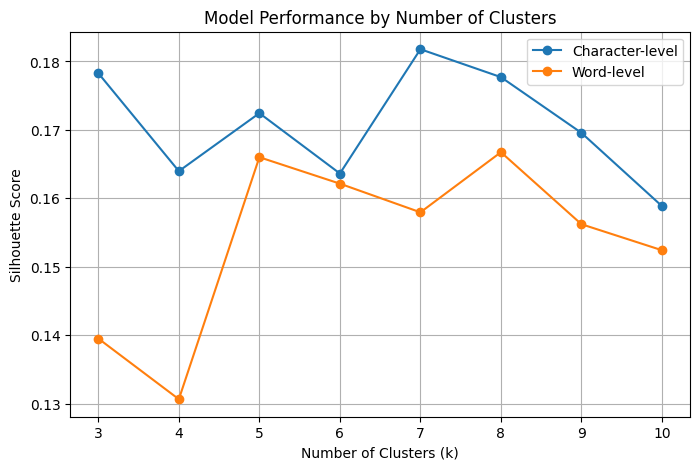

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(results_df["n_clusters"], results_df["char_score"], marker="o", label="Character-level")
plt.plot(results_df["n_clusters"], results_df["word_score"], marker="o", label="Word-level")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Model Performance by Number of Clusters")
plt.legend()
plt.grid(True)
plt.show()

As we can see from the plot above and the table given by the previous cell, the number of clusters (i.e., *hyperparameter* `k`) which gives the highest *silhouette score* in agglomerative clustering is $7$ for character trigrams and $8$ for word unigrams. Moreover, character trigrams generally appear to cluster better than word unigrams.

However, notice that for word unigrams, the silhouette score for k = $5$ is also a local peak close enough to that of k = $8$. In some cases in clustering, it may actually be better choosing a lower hyperparameter as it can provide us with more meaningful, generalized groupings. In this case, since the difference is negligible and we only have $16$ samples to cluster, $5$ may be the better choice.

Hence, we decided to go with k = $5$ for word unigrams and k = $7$ for char unigrams.

In [10]:
CHAR_CLUSTERS = 7 # @param {"type":"integer","placeholder":"7"}
WORD_CLUSTERS = 5 # @param {"type":"integer","placeholder":"5"}

print("=== FINAL CHARACTER MODEL ===")
char_reduced, char_clusters, char_reducer, char_clusterer, char_score = model_pipeline(
    char_matrix,
    reducer_method=REDUCER_METHOD,
    n_components=N_COMPONENTS,
    clusterer_method=CLUSTERER_METHOD,
    n_clusters=CHAR_CLUSTERS,
)

print("\n=== FINAL WORD MODEL ===")
word_reduced, word_clusters, word_reducer, word_clusterer, word_score = model_pipeline(
    word_matrix,
    reducer_method="svd",
    n_components=N_COMPONENTS,
    clusterer_method="agglomerative",
    n_clusters=WORD_CLUSTERS,
)

=== FINAL CHARACTER MODEL ===
Reducing dimensionality using SVD (50 components)...
SVD retained variance: 98.40%
Clustering languages using AGGLOMERATIVE (7 clusters)...
Silhouette score: 0.1818

=== FINAL WORD MODEL ===
Reducing dimensionality using SVD (50 components)...
SVD retained variance: 98.58%
Clustering languages using AGGLOMERATIVE (5 clusters)...
Silhouette score: 0.1660


## Similarity Matrix

With our models chosen, we can now compute the similarity matrices for character trigrams and word unigrams.

In [11]:
from src.similarity import compute_similarity_matrix

char_similarity_df = compute_similarity_matrix(char_reduced).round(3)
word_similarity_df = compute_similarity_matrix(word_reduced).round(3)

In [12]:
char_similarity_df.head(16)

,Bikolano,Cebuano,Chavacano,Ilokano,Isnag,Ivatan,Kalinga,Kankanaey,Kapampangan,Pangasinense,Sambal,Spanish,Tagalog,Tausug,Yakan,Yami
Bikolano,1.000,0.776,0.306,0.442,0.526,0.608,0.640,0.606,0.579,0.706,0.685,0.202,0.780,0.683,0.515,0.554
Cebuano,0.776,1.000,0.294,0.408,0.485,0.475,0.490,0.418,0.607,0.543,0.506,0.168,0.917,0.544,0.421,0.447
Chavacano,0.306,0.294,1.000,0.259,0.335,0.376,0.309,0.302,0.204,0.373,0.362,0.670,0.275,0.285,0.259,0.331
Ilokano,0.442,0.408,0.259,1.000,0.444,0.504,0.429,0.454,0.346,0.506,0.483,0.202,0.410,0.375,0.307,0.481
Isnag,0.526,0.485,0.335,0.444,1.000,0.493,0.541,0.565,0.396,0.544,0.545,0.168,0.473,0.508,0.346,0.463
Ivatan,0.608,0.475,0.376,0.504,0.493,1.000,0.521,0.545,0.377,0.654,0.632,0.313,0.453,0.464,0.357,0.823
Kalinga,0.640,0.490,0.309,0.429,0.541,0.521,1.000,0.628,0.466,0.623,0.581,0.178,0.485,0.603,0.474,0.461
Kankanaey,0.606,0.418,0.302,0.454,0.565,0.545,0.628,1.000,0.379,0.704,0.672,0.186,0.471,0.494,0.395,0.499
Kapampangan,0.579,0.607,0.204,0.346,0.396,0.377,0.466,0.379,1.000,0.473,0.437,0.143,0.839,0.460,0.361,0.445
Pangasinense,0.706,0.543,0.373,0.506,0.544,0.654,0.623,0.704,0.473,1.000,0.758,0.266,0.543,0.570,0.459,0.644


In [13]:
word_similarity_df.head(16)

,Bikolano,Cebuano,Chavacano,Ilokano,Isnag,Ivatan,Kalinga,Kankanaey,Kapampangan,Pangasinense,Sambal,Spanish,Tagalog,Tausug,Yakan,Yami
Bikolano,1.000,0.424,0.107,0.023,0.182,0.215,0.223,0.024,0.175,0.214,0.202,0.012,0.453,0.124,0.063,0.198
Cebuano,0.424,1.000,0.025,0.074,0.140,0.123,0.026,0.015,0.022,0.026,0.026,0.005,0.643,0.023,0.049,0.026
Chavacano,0.107,0.025,1.000,0.020,0.263,0.114,0.140,0.164,0.142,0.180,0.162,0.438,0.080,0.049,0.098,0.135
Ilokano,0.023,0.074,0.020,1.000,0.102,0.365,0.012,0.054,0.161,0.283,0.371,0.176,0.029,0.001,0.001,0.339
Isnag,0.182,0.140,0.263,0.102,1.000,0.163,0.182,0.362,0.258,0.261,0.278,0.056,0.174,0.108,0.046,0.200
Ivatan,0.215,0.123,0.114,0.365,0.163,1.000,0.109,0.055,0.284,0.490,0.499,0.217,0.135,0.063,0.029,0.982
Kalinga,0.223,0.026,0.140,0.012,0.182,0.109,1.000,0.060,0.123,0.142,0.096,0.034,0.073,0.088,0.138,0.153
Kankanaey,0.024,0.015,0.164,0.054,0.362,0.055,0.060,1.000,0.031,0.067,0.264,0.027,0.092,0.011,0.038,0.036
Kapampangan,0.175,0.022,0.142,0.161,0.258,0.284,0.123,0.031,1.000,0.344,0.283,0.131,0.211,0.111,0.030,0.279
Pangasinense,0.214,0.026,0.180,0.283,0.261,0.490,0.142,0.067,0.344,1.000,0.501,0.159,0.130,0.104,0.050,0.549


Let's visualize these matrices with a heatmap and their respective dendograms.

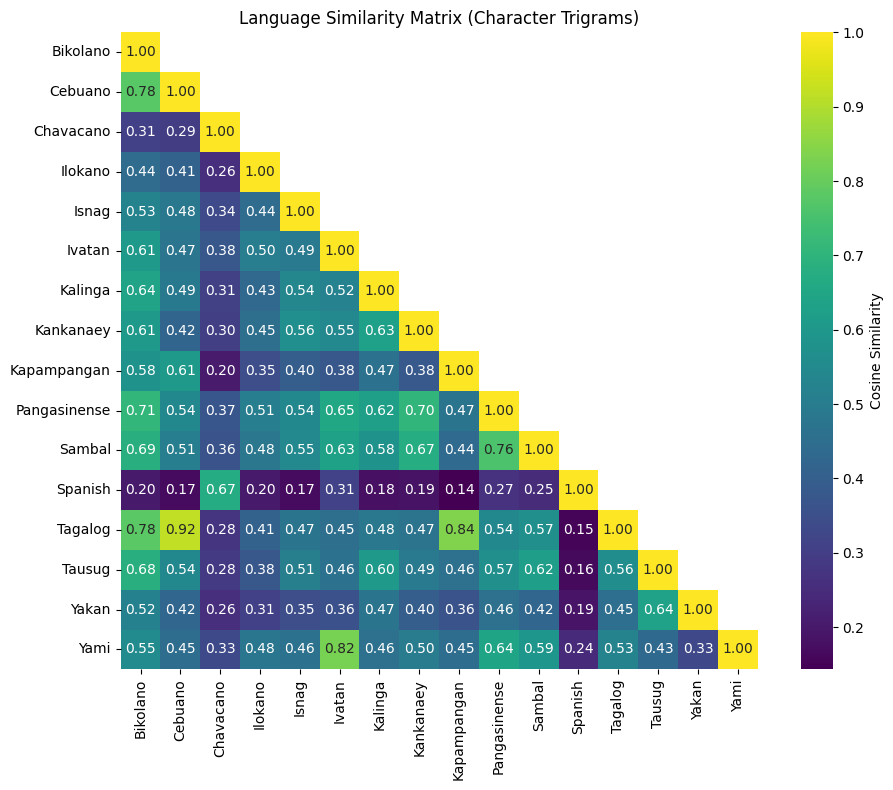

In [14]:
import numpy as np
import seaborn as sns

# Mask the upper triangle
mask = np.triu(np.ones_like(char_similarity_df, dtype=bool), 1)

plt.figure(figsize=(10, 8))
sns.heatmap(
    char_similarity_df,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    square=True,
    cbar_kws={"label": "Cosine Similarity"},
  )
plt.title("Language Similarity Matrix (Character Trigrams)")
plt.tight_layout()
plt.show()

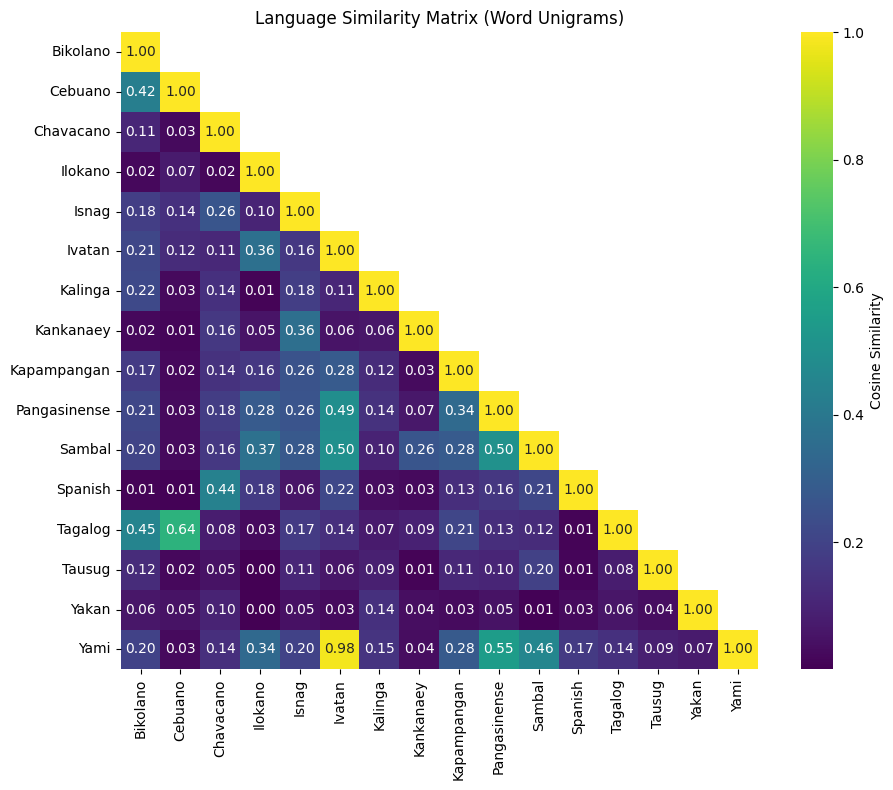

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    word_similarity_df,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    square=True,
    cbar_kws={"label": "Cosine Similarity"},
  )
plt.title("Language Similarity Matrix (Word Unigrams)")
plt.tight_layout()
plt.show()

It is at this point that the authors realized they could not directly use the derived agglomerative clusters to create the *language dendograms* as the languages actually had to be clustered hierarchically to do so.

Fortunately, the reduced feature matrices (i.e., feature matrix obtained after dimensionality reduction) for both character and word ngrams could still be used for hierarchical clustering.



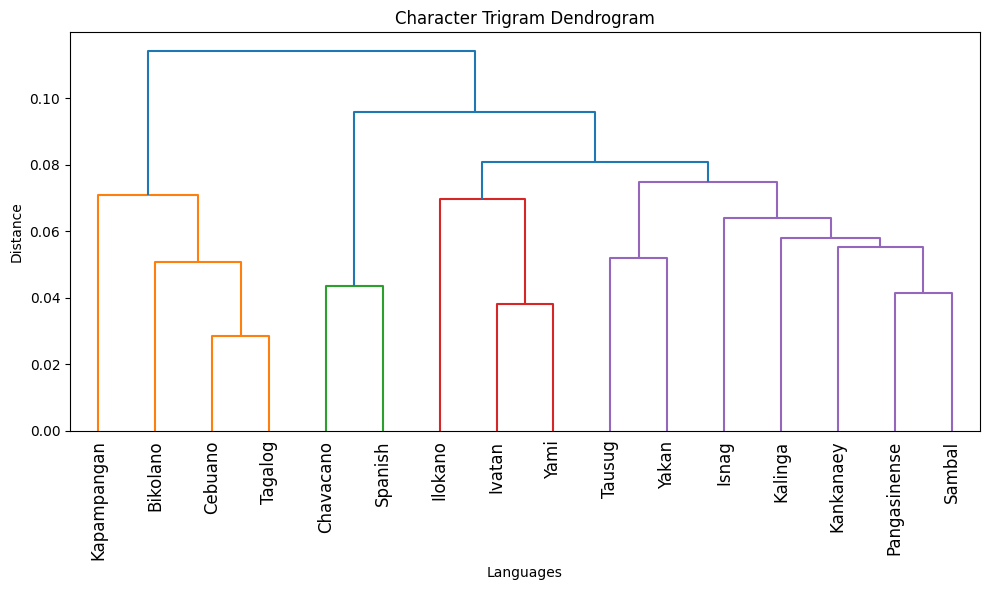

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z_char = linkage(char_reduced, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(Z_char, labels=char_reduced.index, leaf_rotation=90)
plt.title("Character Trigram Dendrogram")
plt.xlabel("Languages")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

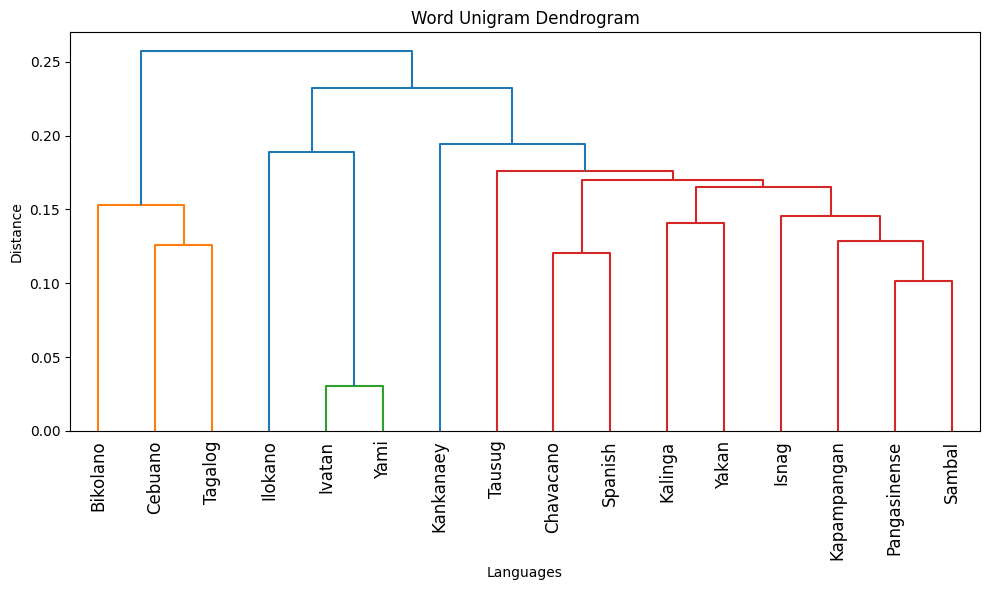

In [17]:
Z_word = linkage(word_reduced, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(Z_word, labels=word_reduced.index, leaf_rotation=90)
plt.title("Word Unigram Dendrogram")
plt.xlabel("Languages")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

### Interpretations

By computing the similarity matrices, we can gain insights into how closely related various Philippine languages are in terms of their structural and lexical characteristics. The heatmaps visually represent these relationships, where darker shades correspond to higher similarity values. This allows us to identify which languages share common linguistic features at a glance.

For instance, languages that exhibit high character trigram similarity (such as Tagalog and Cebuano) likely share orthographic patterns, indicating that they may use similar combinations of letters. Meanwhile, high word unigram similarity values (such as Yami and Ivatan) suggest overlaps in lexical choice and grammatical tendencies, reflecting either shared vocabulary.

To complement these observations, dendrograms were constructed using Ward’s linkage method, which groups languages hierarchically based on their pairwise similarities. These tree-like diagrams reveal how languages cluster together at different thresholds of similarity. For example, closely related languages may merge at lower levels of the hierarchy, while more distantly related ones join at higher levels.

From these hierarchical groupings, we can infer possible linguistic families or subgroups within the Philippine language set. Depending on which similarity measure is used (character trigram or word unigram), the clusters may differ, indicating that languages can be grouped in multiple ways depending on whether the focus is orthographic, lexical, or grammatical resemblance. This highlights the complex and multidimensional nature of language relationships within the Philippines, where shared history, geography, and influence may shape linguistic similarity.